### Compare fits for pct_high, pct_low, ... etc

#### 'Disabling' numba has no effect
import os
check = os.environ.get("ARCH_DISABLE_NUMBA", True)

In [1]:
import time

import numpy as np

start_time = time.time()

In [2]:
from sqlalchemy import create_engine
engine = create_engine('mysql+pymysql://localhost',
                       connect_args={'read_default_file': '~/.mytest.cnf'})
conn = engine.connect()

In [3]:
import pandas as pd
tck_qry = pd.read_sql_query('''select distinct us.symbol, avg(us.volume*us.close) from USE_2021 us
join US_SymsWithOptions USWO on us.symbol = USWO.Symbol
where USWO.`Symbol Type` = 'Equity'
    group by us.symbol order by avg(us.volume*us.close) desc limit 500''',
                            conn)
tdf = pd.DataFrame(tck_qry, columns=['symbol'])
tickers = tdf['symbol']
prices = ["pct_open", "pct_high", "pct_low", "pct_close",
          'pct_hilo', 'pct_opclo']
#prices = ["pct_hilo"]

In [4]:
sql_diff = time.time() - start_time
formatted_diff = "{:.2f}".format(sql_diff)
print("sql executed in ", formatted_diff, " secs")

sql executed in  1.65  secs


In [5]:
def query_symbol(sym, conn):
    qry = pd.read_sql_query(
        '''select tradedate, pct_open, pct_high, pct_low, pct_close,
         pct_hilo, pct_opclo from USEQ_HIST
        where symbol="''' + sym + '''"
        and volume>0
         order by tradedate''',
        conn,
        index_col='tradedate'
    )
    return sym, pd.DataFrame(qry, columns=prices)

In [6]:
import math
def ann_var(var):
    return (math.sqrt((var)*252))

In [7]:
from arch import arch_model

In [8]:
rows = []
#tickers=pd.Series(data=['MS']).append(tickers)
#tickers=pd.Series(data=['BYND']).append(tickers)
#tickers=pd.Series(data=['DIS']).append(tickers)

step = 0
steps = 201
time_last = time.time()
for tk in tickers:
    ticker, df = query_symbol(tk, conn)
    for pr in prices:
        if(len(df.index)<800):
            continue
        if step % steps == 0:
            print("fitting symbol: ", tk, "  for price: ", pr, "len(df): ", len(df.index))
            time_now = time.time()
            time_spent = time_now - time_last
            time_last = time_now
            formatted = "{:.2f}".format(time_spent)
            print(steps, " executed in ", formatted, " secs")
        am = arch_model(df[pr], p=1, o=1, q=1, dist="StudentsT", rescale=False)
        res = am.fit(disp='off')
        if res.convergence_flag != 0:
            continue
        forecasts = res.forecast(reindex=False)
        row = [tk, pr, res.loglikelihood, ann_var(forecasts.variance['h.1'].iloc[0])
               ,forecasts.mean['h.1'].iloc[0], res.nobs]
        rows.append(row)
        step += 1
    cmp = pd.DataFrame(rows, columns=['ticker', 'price', 'lhood', 'volatilty', 'mean', 'nobs'])

compare = cmp.set_index(['ticker', 'price'])
compare.head(36)

fitting symbol:  TSLA   for price:  pct_open len(df):  1477
201  executed in  0.02  secs
fitting symbol:  QCOM   for price:  pct_close len(df):  1477
201  executed in  7.04  secs
fitting symbol:  FCX   for price:  pct_open len(df):  1475
201  executed in  6.94  secs
fitting symbol:  ASML   for price:  pct_close len(df):  1477
201  executed in  6.50  secs
fitting symbol:  MMM   for price:  pct_open len(df):  1475
201  executed in  7.04  secs
fitting symbol:  LVS   for price:  pct_close len(df):  1475
201  executed in  6.68  secs
fitting symbol:  CCI   for price:  pct_open len(df):  1475
201  executed in  6.77  secs
fitting symbol:  CZR   for price:  pct_close len(df):  1477
201  executed in  6.91  secs


/home/kwoodle/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


fitting symbol:  CP   for price:  pct_high len(df):  1475
201  executed in  7.11  secs
fitting symbol:  WM   for price:  pct_hilo len(df):  1475
201  executed in  6.88  secs
fitting symbol:  MCK   for price:  pct_high len(df):  1475
201  executed in  6.60  secs
fitting symbol:  LH   for price:  pct_hilo len(df):  1475
201  executed in  6.58  secs
fitting symbol:  CREE   for price:  pct_high len(df):  1448
201  executed in  6.76  secs


lhood  volatilty      mean  nobs
ticker price                                            
TSLA   pct_open  -3775.737727  92.699686  0.164966  1477
       pct_high  -3617.709975  67.416022  0.167387  1477
       pct_low   -3668.949665  71.167838  0.239415  1477
       pct_close -3739.816685  68.324805  0.189788  1477
       pct_hilo  -3042.597365  88.224586  3.155574  1477
       pct_opclo -3472.913556  71.461778 -0.030156  1477
AAPL   pct_open  -2711.171496  18.828448  0.161650  1477
       pct_high  -2494.183178  20.196766  0.134665  1477
       pct_low   -2630.989864  21.671953  0.178222  1477
       pct_close -2705.437250  22.429252  0.142629  1477
       pct_hilo  -2013.241695  11.149129  1.513104  1477
       pct_opclo -2332.760456  16.294813 -0.115566  1477
AMZN   pct_open  -2806.214090  26.739032  0.153960  1477
       pct_high  -2577.231315  25.920938  0.138367  1477
       pct_low   -2732.767198  23.457154  0.147358  1477
       pct_close -2756.025252  29.805763  0.138990  1477
       pct_hilo  -2133.446301  24.339229  1.583225  1477
       pct_opclo -2507.561444  26.087764 -0.001820  1477
MSFT   pct_open  -2482.534553  16.725714  0.125110  1477
       pct_high  -2240.649585  16.317818  0.143031  1477
       pct_low   -2399.483243  15.606284  0.127474  1477
       pct_close -2519.755064  18.434251  0.125556  1477
       pct_hilo  -1821.528480   9.554579  1.389972  1477
       pct_opclo -2213.749164  14.906075 -0.057902  1477
NVDA   pct_open  -3481.081250  84.248906  0.289144  1477
       pct_high  -3222.099650  44.867675  0.263247  1477
       pct_low   -3373.384010  48.624770  0.336038  1477
       pct_close -3464.501233  51.642885  0.270527  1477
       pct_hilo  -2666.639665  38.325128  2.617894  1477
       pct_opclo -3146.907335  44.022047 -0.067580  1477
FB     pct_open  -2892.602070  33.189216  0.117888  1477
       pct_high  -2651.153741  29.616865  0.102500  1477
       pct_low   -2771.088768  34.007490  0.142111  1477
       pct_close -2853.914087  33.916199  0.114989  1477
       pct_hilo  -2259.876546  13.213917  1.818153  1477
       pct_opclo -2555.452122  23.408814 -0.048146  1477

In [9]:
total_rows = len(cmp.index)
time_now = time.time()
elapsed_sec = time_now - start_time
elapsed_min = elapsed_sec/60.
elapsed_minf = "{:.2f}".format(elapsed_min)
elapsed_secf = "{:.2f}".format(elapsed_sec)
print(total_rows, " rows processed in ", elapsed_minf, " minutes.")
rows_per_sec = total_rows/elapsed_sec
rows_per_secf = "{:.2f}".format(rows_per_sec)
print(rows_per_secf, " rows processed per second.")

2489  rows processed in  1.45  minutes.
28.62  rows processed per second.


<AxesSubplot:ylabel='Frequency'>

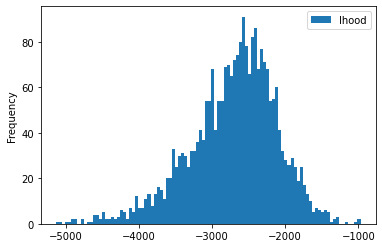

In [10]:
compare[['lhood']].plot(bins=100, kind='hist')

<AxesSubplot:ylabel='Frequency'>

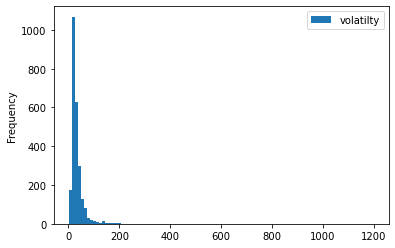

In [11]:
compare[['volatilty']].plot(bins=100, kind='hist')

In [12]:
conn.close()